In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
import os
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader


In [4]:
curr_dir = os.getcwd()
plots_dir = os.path.join(curr_dir,"Plots")

In [5]:
print(os.path.join(curr_dir,'Plots'))

/home/simone/Projects/VAEs/Plots


In [6]:
def train_Rt(enc,dec,q,x_data,opt,Rt,N_EPOCHS=500,lr_b = 0.1,e_switch=500):
    #Train parameters of VAE specified in `opt`
    history = { "loss" : [],
                "distortion" : [],
                "rate" : [],
                "beta" : [1]   }

    for e in range(N_EPOCHS):
        lav = dav = rav = 0
        beta = history["beta"][-1]
        #if e == e_switch:
        #    opt.param_groups[0]['lr'] = 1E-4
        for x_ in x_data:
            rate = q(enc,x_)
            distortion = distortion_analytical_linear(x_,enc,dec,q.r_all)
            #distortion = distortion_gaussian(x_,enc,dec,tau=0.01)
            loss =  distortion +beta*rate
            opt.zero_grad()
            loss.backward()
            opt.step()
            lav += distortion + rate
            dav += distortion
            rav += rate
        if torch.isnan(loss):
            break;
        history["loss"].append(lav.item()/len(x_data))
        history["rate"].append(rav.item()/len(x_data))
        history["distortion"].append(dav.item()/len(x_data))
        #Update constraint
        beta += lr_b*(history["rate"][-1]-Rt)
        beta = beta if beta>0 else 0
        history["beta"].append(beta)
        print(f'Epoch: {e} ||Rate: {history["rate"][-1]}||',
            f'ELBO:{history["loss"][-1]}||',
            f'Distortion: {history["distortion"][-1]}||Beta = {history["beta"][-1]}')
    history["beta"].pop()
    return history

In [7]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.3,0.2,0.5]))
gs = torch.distributions.normal.Normal(torch.Tensor([-4,0,2]),torch.tensor([1,0.5,1]))
#p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.log_normal.LogNormal(1,1)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 3000
N_SAMPLES =5000
lr = 1e-2
BATCH_SIZE = 256
#Generate dataset
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_test = p_x.sample((10000,))[:,None]
x_tsorted,_ = x_test.sort(dim=0)
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
#p_x.entropy()

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$f_i$')]

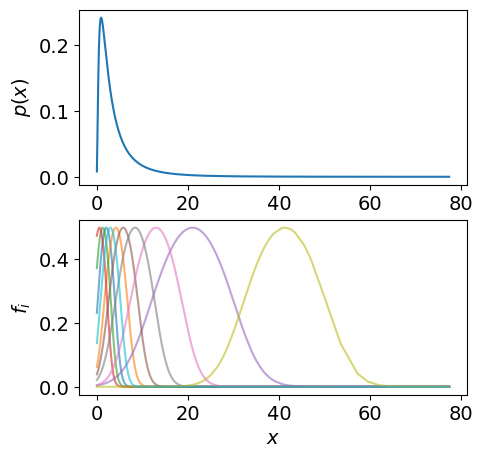

In [16]:
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted,w=2)
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:]*3 )
#c_in = enc.cs.clone()
#sigma_in = enc.log_sigmas.clone()
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
q = rate_ising(N)
#q = rate_bernoulli(N)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
#phi0 = torch.cat((enc.cs*torch.exp(-2*enc.log_sigmas),torch.exp(-2*enc.log_sigmas))).transpose(0,1)

#dec = GaussianDecoder(phi0)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_sorted,torch.exp(p_x.log_prob(x_sorted)).detach())
axs[0].set_xlabel("x (stimulus)")
axs[0].set_ylabel(r"$p(x)$")
#axs[0].plot(h.bin_edges[0:-1],torch.log10(h.hist))
#axs[0].set_xscale("log")
axs[1].plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach(),alpha=0.6)
axs[1].set(xlabel=r"$x$",ylabel=r"$f_i$")
#axs[1].set_xscale("log")


In [17]:
q.h

Parameter containing:
tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]],
       requires_grad=True)

In [18]:
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
opt = torch.optim.Adam(params,1e-4)
Rt = 0.7
history = train_Rt(enc,dec,q,x_data,opt,Rt,N_EPOCHS = 3000,lr_b = 0.1)

Epoch: 0 ||Rate: 1.5046809196472168|| ELBO:19.620816040039063|| Distortion: 18.11613311767578||Beta = 1.0804680919647216
Epoch: 1 ||Rate: 1.4890551567077637|| ELBO:18.567807006835938|| Distortion: 17.078753662109374||Beta = 1.159373607635498
Epoch: 2 ||Rate: 1.4731937408447267|| ELBO:17.60920104980469|| Distortion: 16.136007690429686||Beta = 1.2366929817199706
Epoch: 3 ||Rate: 1.457187557220459|| ELBO:16.732322692871094|| Distortion: 15.27513427734375||Beta = 1.3124117374420163
Epoch: 4 ||Rate: 1.441188144683838|| ELBO:15.927876281738282|| Distortion: 14.486688232421875||Beta = 1.3865305519104
Epoch: 5 ||Rate: 1.4252902030944825|| ELBO:15.185276794433594|| Distortion: 13.759988403320312||Beta = 1.4590595722198483
Epoch: 6 ||Rate: 1.4095458030700683|| ELBO:14.49823455810547|| Distortion: 13.088687133789062||Beta = 1.5300141525268551
Epoch: 7 ||Rate: 1.3939853668212892|| ELBO:13.85992889404297|| Distortion: 12.465943908691406||Beta = 1.5994126892089842
Epoch: 8 ||Rate: 1.37863187789917||

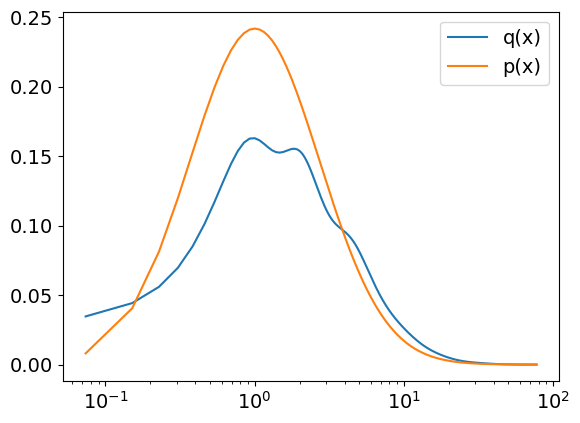

In [19]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all ,1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,torch.exp(q_x.log_prob(x_fine)),label= "q(x)")
    axs.plot(x_fine,torch.exp(p_x.log_prob(x_fine)),label= "p(x)")
    axs.legend()
    axs.set_xscale("log")

In [1]:
fig,ax = training_plots(history["loss"],history["distortion"],history["rate"],history["beta"])
#fig.savefig("beta1_training.pdf")

NameError: name 'training_plots' is not defined

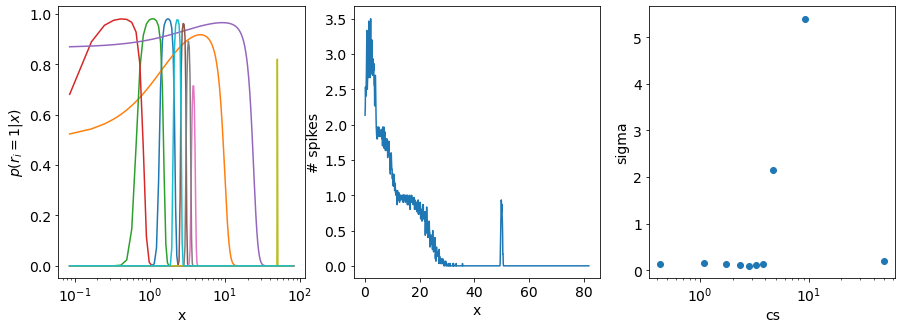

In [45]:
fig,axs = encoder_plots(enc,x_fine)
axs[0].set_xscale("log")
axs[2].set_xscale("log")

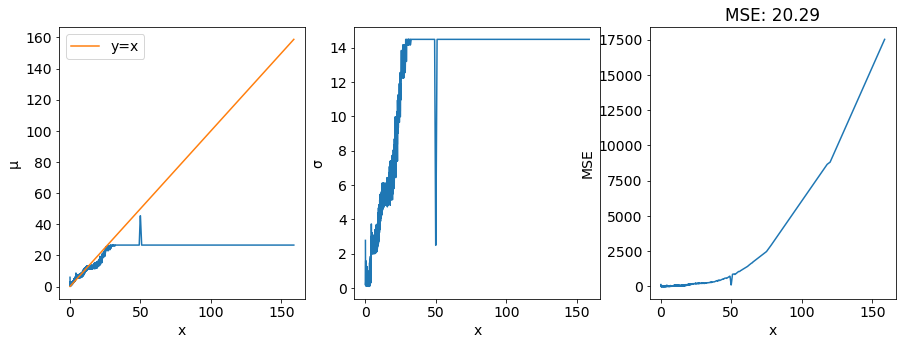

In [46]:
fig,axs,mse = decoder_plots(enc,dec,x_tsorted)
#axs[2].set_xscale("log")
#axs[2].set_yscale("log")
#fig.savefig("beta1_decoder.pdf")

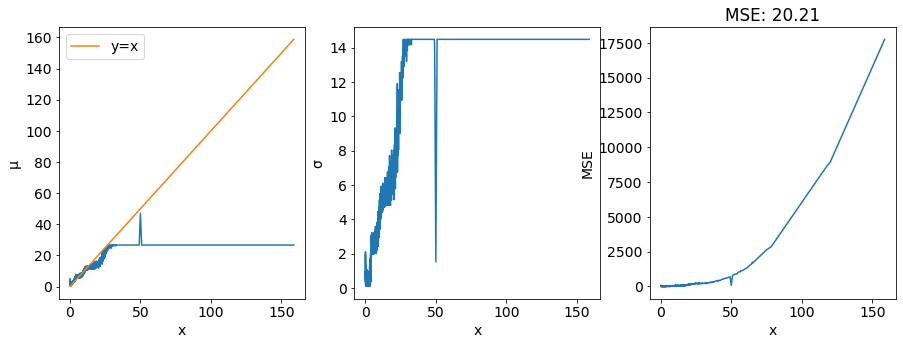

In [47]:
fig,axs,mse = decoder_plots(enc,dec,x_tsorted)

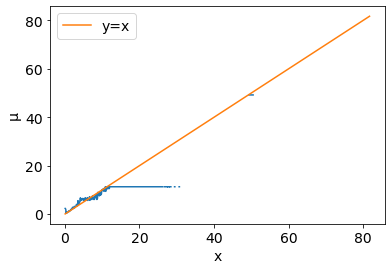

In [48]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')

AttributeError: 'rate_bernoulli' object has no attribute 'J'

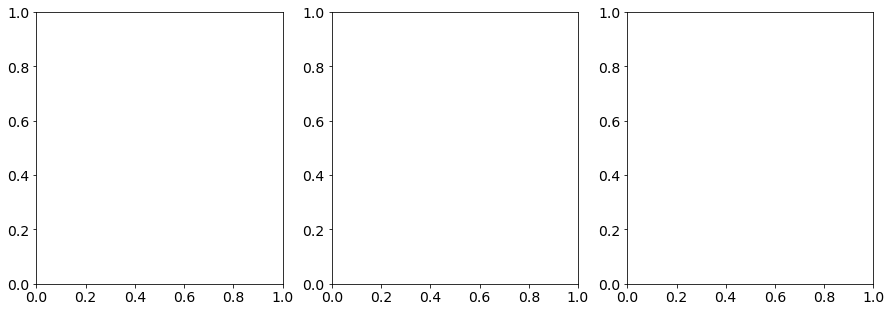

In [49]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
axs[0].set_yscale("log")
#fig.savefig("beta1_gm.pdf")

In [36]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all + (q.r_all*(q.J@q.r_all)).sum(dim=0),1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,torch.log10(torch.exp(q_x.log_prob(x_fine))),label= "q(x)")
    axs.plot(fs,torch.log10(pf),label= "p(x)")
    axs.legend()
    axs.set_xscale("log")

AttributeError: 'rate_bernoulli' object has no attribute 'J'

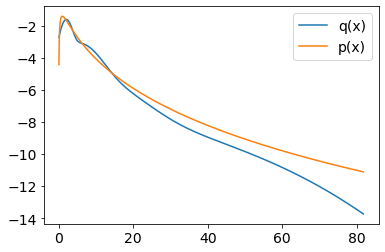

In [37]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all ,1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,q_x.log_prob(x_fine),label= "q(x)")
    axs.plot(x_fine,p_x.log_prob(x_fine),label= "p(x)")
    axs.legend()
    #axs.set_xscale("log")

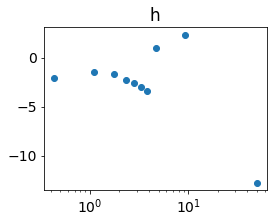

In [52]:
with torch.no_grad():
    fig,axs = plt.subplots(figsize=(4,3))
    _,indices = enc.cs.sort(dim=1)
    indices = torch.squeeze(indices)
    axs.scatter(enc.cs[0,indices],q.h[0,indices])
    #im= axs.imshow(q_.J[:,indices][indices,:],vmin=-10,vmax = 3)
    #plt.colorbar(im,ax=axs,location= "bottom")
    axs.set(xscale="log")
    axs.set_title('h')